# Шумоподавляющий Автоэнкодер

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])

dataset = MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - (val_size + train_size)

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, z=32):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(channels, ch, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)

        self.conv2 = nn.Conv2d(ch, ch * 2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(ch * 2)

        self.conv3 = nn.Conv2d(ch * 2, ch * 4, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(ch * 4)

        self.conv_out = nn.Conv2d(ch * 4, z, kernel_size=4, stride=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv_out(x)
        return x

class Decoder(nn.Module):
    def __init__(self, channels, ch=32, z=32):
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(z, ch * 4, kernel_size=4, stride=1)
        self.bn1 = nn.BatchNorm2d(ch * 4)

        self.conv2 = nn.ConvTranspose2d(ch * 4, ch * 2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(ch * 2)

        self.conv3 = nn.ConvTranspose2d(ch * 2, ch, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(ch)

        self.conv4 = nn.ConvTranspose2d(ch, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.tanh(self.conv4(x))
        return x

class AE(nn.Module):
    def __init__(self, channel_in, ch=32, z=32):
        super(AE, self).__init__()
        self.encoder = Encoder(channel_in, ch, z)
        self.decoder = Decoder(channel_in, ch, z)

    def forward(self, x):
        encoding = self.encoder(x)
        x = self.decoder(encoding)
        return x, encoding

In [5]:
def add_noise(images, noise_factor=0.2):
  noisy = images + noise_factor * torch.randn_like(images)
  noisy = torch.clamp(noisy, -1., 1.)
  return noisy

Epoch 1/20:   0%|          | 0/563 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/20: 100%|██████████| 563/563 [01:37<00:00,  5.80it/s]



Epoch 1/20
Train Loss: 0.0243 | Dice: 0.7565 | IoU: 0.6340
Val   Loss: 0.0084 | Dice: 0.8838 | IoU: 0.7919
✔ Model improved. Saved to best_ae_model.pth


Epoch 2/20: 100%|██████████| 563/563 [01:31<00:00,  6.12it/s]



Epoch 2/20
Train Loss: 0.0071 | Dice: 0.8958 | IoU: 0.8113
Val   Loss: 0.0061 | Dice: 0.9032 | IoU: 0.8235
✔ Model improved. Saved to best_ae_model.pth


Epoch 3/20: 100%|██████████| 563/563 [01:31<00:00,  6.15it/s]



Epoch 3/20
Train Loss: 0.0056 | Dice: 0.9079 | IoU: 0.8314
Val   Loss: 0.0051 | Dice: 0.9120 | IoU: 0.8383
✔ Model improved. Saved to best_ae_model.pth


Epoch 4/20: 100%|██████████| 563/563 [01:32<00:00,  6.06it/s]



Epoch 4/20
Train Loss: 0.0049 | Dice: 0.9139 | IoU: 0.8414
Val   Loss: 0.0049 | Dice: 0.9124 | IoU: 0.8390
✔ Model improved. Saved to best_ae_model.pth


Epoch 5/20: 100%|██████████| 563/563 [01:32<00:00,  6.06it/s]



Epoch 5/20
Train Loss: 0.0045 | Dice: 0.9176 | IoU: 0.8477
Val   Loss: 0.0043 | Dice: 0.9192 | IoU: 0.8504
✔ Model improved. Saved to best_ae_model.pth


Epoch 6/20: 100%|██████████| 563/563 [01:32<00:00,  6.10it/s]



Epoch 6/20
Train Loss: 0.0043 | Dice: 0.9196 | IoU: 0.8512
Val   Loss: 0.0040 | Dice: 0.9217 | IoU: 0.8548
✔ Model improved. Saved to best_ae_model.pth


Epoch 7/20: 100%|██████████| 563/563 [01:32<00:00,  6.07it/s]



Epoch 7/20
Train Loss: 0.0041 | Dice: 0.9216 | IoU: 0.8547
Val   Loss: 0.0038 | Dice: 0.9230 | IoU: 0.8571
✔ Model improved. Saved to best_ae_model.pth


Epoch 8/20: 100%|██████████| 563/563 [01:31<00:00,  6.14it/s]



Epoch 8/20
Train Loss: 0.0039 | Dice: 0.9235 | IoU: 0.8579
Val   Loss: 0.0038 | Dice: 0.9245 | IoU: 0.8597
✔ Model improved. Saved to best_ae_model.pth


Epoch 9/20: 100%|██████████| 563/563 [01:32<00:00,  6.09it/s]



Epoch 9/20
Train Loss: 0.0038 | Dice: 0.9245 | IoU: 0.8596
Val   Loss: 0.0037 | Dice: 0.9246 | IoU: 0.8599
✔ Model improved. Saved to best_ae_model.pth


Epoch 10/20: 100%|██████████| 563/563 [01:31<00:00,  6.17it/s]



Epoch 10/20
Train Loss: 0.0037 | Dice: 0.9253 | IoU: 0.8611
Val   Loss: 0.0037 | Dice: 0.9251 | IoU: 0.8606


Epoch 11/20: 100%|██████████| 563/563 [01:31<00:00,  6.15it/s]



Epoch 11/20
Train Loss: 0.0035 | Dice: 0.9266 | IoU: 0.8632
Val   Loss: 0.0034 | Dice: 0.9277 | IoU: 0.8652
✔ Model improved. Saved to best_ae_model.pth


Epoch 12/20: 100%|██████████| 563/563 [01:32<00:00,  6.09it/s]



Epoch 12/20
Train Loss: 0.0035 | Dice: 0.9272 | IoU: 0.8643
Val   Loss: 0.0035 | Dice: 0.9274 | IoU: 0.8646


Epoch 13/20: 100%|██████████| 563/563 [01:31<00:00,  6.16it/s]



Epoch 13/20
Train Loss: 0.0034 | Dice: 0.9282 | IoU: 0.8661
Val   Loss: 0.0033 | Dice: 0.9281 | IoU: 0.8658
✔ Model improved. Saved to best_ae_model.pth


Epoch 14/20: 100%|██████████| 563/563 [01:31<00:00,  6.14it/s]



Epoch 14/20
Train Loss: 0.0033 | Dice: 0.9287 | IoU: 0.8669
Val   Loss: 0.0033 | Dice: 0.9287 | IoU: 0.8670


Epoch 15/20: 100%|██████████| 563/563 [01:33<00:00,  6.03it/s]



Epoch 15/20
Train Loss: 0.0033 | Dice: 0.9294 | IoU: 0.8681
Val   Loss: 0.0032 | Dice: 0.9291 | IoU: 0.8676
✔ Model improved. Saved to best_ae_model.pth


Epoch 16/20: 100%|██████████| 563/563 [01:32<00:00,  6.11it/s]



Epoch 16/20
Train Loss: 0.0032 | Dice: 0.9301 | IoU: 0.8694
Val   Loss: 0.0033 | Dice: 0.9285 | IoU: 0.8665


Epoch 17/20: 100%|██████████| 563/563 [01:30<00:00,  6.20it/s]



Epoch 17/20
Train Loss: 0.0031 | Dice: 0.9307 | IoU: 0.8704
Val   Loss: 0.0032 | Dice: 0.9304 | IoU: 0.8699
✔ Model improved. Saved to best_ae_model.pth


Epoch 18/20: 100%|██████████| 563/563 [01:34<00:00,  5.94it/s]



Epoch 18/20
Train Loss: 0.0031 | Dice: 0.9309 | IoU: 0.8708
Val   Loss: 0.0031 | Dice: 0.9302 | IoU: 0.8695
✔ Model improved. Saved to best_ae_model.pth


Epoch 19/20: 100%|██████████| 563/563 [01:32<00:00,  6.07it/s]



Epoch 19/20
Train Loss: 0.0030 | Dice: 0.9316 | IoU: 0.8721
Val   Loss: 0.0032 | Dice: 0.9299 | IoU: 0.8691


Epoch 20/20: 100%|██████████| 563/563 [01:31<00:00,  6.15it/s]



Epoch 20/20
Train Loss: 0.0030 | Dice: 0.9321 | IoU: 0.8729
Val   Loss: 0.0030 | Dice: 0.9326 | IoU: 0.8738
✔ Model improved. Saved to best_ae_model.pth
✅ Best model loaded from best_ae_model.pth

Test Results:
Test Loss: 0.0030
Dice Coefficient: 0.9329
IoU Score: 0.8743


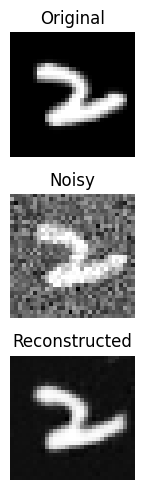

In [6]:
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(channel_in=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

patience = 3
best_val_loss = float("inf")
patience_counter = 0
model_path = "best_ae_model.pth"

def dice_coeff(pred, target):
    smooth = 1
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def iou_score(pred, target):
    smooth = 1
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    for clean_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        clean_images = clean_images.to(device)
        noisy_images = add_noise(clean_images)

        optimizer.zero_grad()
        outputs, _ = model(noisy_images)

        loss = criterion(outputs, clean_images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        outputs_bin = (outputs > 0.5).float()
        clean_bin = (clean_images > 0.5).float()

        running_dice += dice_coeff(outputs_bin, clean_bin)
        running_iou += iou_score(outputs_bin, clean_bin)

    train_loss = running_loss / len(train_loader)
    train_dice = running_dice / len(train_loader)
    train_iou = running_iou / len(train_loader)

    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for clean_images, _ in val_loader:
            clean_images = clean_images.to(device)
            noisy_images = add_noise(clean_images)
            outputs, _ = model(noisy_images)

            val_loss += criterion(outputs, clean_images).item()

            outputs_bin = (outputs > 0.5).float()
            clean_bin = (clean_images > 0.5).float()

            val_dice += dice_coeff(outputs_bin, clean_bin)
            val_iou += iou_score(outputs_bin, clean_bin)

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"✔ Model improved. Saved to {model_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping triggered!")
            break

model.load_state_dict(torch.load(model_path))
model.to(device)
print(f"✅ Best model loaded from {model_path}")

model.eval()
test_loss = 0.0
test_dice = 0.0
test_iou = 0.0

with torch.no_grad():
    for clean_images, _ in test_loader:
        clean_images = clean_images.to(device)
        noisy_images = add_noise(clean_images)
        outputs, _ = model(noisy_images)

        test_loss += criterion(outputs, clean_images).item()
        outputs_bin = (outputs > 0.5).float()
        clean_bin = (clean_images > 0.5).float()

        test_dice += dice_coeff(outputs_bin, clean_bin)
        test_iou += iou_score(outputs_bin, clean_bin)

test_loss /= len(test_loader)
test_dice /= len(test_loader)
test_iou /= len(test_loader)

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Dice Coefficient: {test_dice:.4f}")
print(f"IoU Score: {test_iou:.4f}")

def plot_results(model, test_loader, device, num_images=1):
    model.eval()
    with torch.no_grad():
        data = next(iter(test_loader))
        clean_images, _ = data
        clean_images = clean_images[:num_images].to(device)
        noisy_images = add_noise(clean_images)
        outputs, _ = model(noisy_images)

        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            plt.subplot(3, num_images, i+1)
            plt.imshow(clean_images[i].cpu().squeeze(), cmap='gray')
            plt.title("Original")
            plt.axis('off')

            plt.subplot(3, num_images, num_images+i+1)
            plt.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
            plt.title("Noisy")
            plt.axis('off')

            plt.subplot(3, num_images, 2*num_images+i+1)
            plt.imshow(outputs[i].cpu().squeeze(), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

plot_results(model, test_loader, device)

In [7]:
from google.colab import files
files.download("best_ae_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>